In [23]:
import os
import pickle
import subprocess as subp
from math import sqrt
from pathlib import Path
from time import monotonic

if not Path("timing.pkl").exists():
    # adjust this to your CRMC path
    crmc_path = "../../crmc/build"

    crmc_path = Path(crmc_path)
    assert crmc_path.exists()

    timing = {}

    model_codes = {
        "SIBYLL-2.3d": (6, 1e5),
        "QGSJet-II-04": (7, 1e4),
        "EposLHC": (0, 1e4),
    }
    energies = [100, 1000, 10000, 100000]  # GeV

    outfile = os.devnull
    for model, (code, size) in model_codes.items():
        print("  ", model)
        times_crmc = []
        times_chromo = []
        for energy in energies:
            print("    ", energy)
            nevent = int(size / sqrt(energy))
            if model == "SIBYLL-2.3d":
                nevent *= 10
            if model == "QGSJet-II-04":
                nevent *= 10
            t = monotonic()
            cmd = [
                "python",
                "-m",
                "chromo",
                "-s",
                "2",
                "-m",
                f"{code}",
                "-S",
                f"{energy}",
                "-n",
                f"{nevent}",
                "-o",
                "hepmc",
                "-f",
                "foo"
            ]
            print("       ", " ".join(cmd))
            subp.run(cmd, stdin=subp.PIPE, stdout=subp.PIPE, check=False)
            times_chromo.append(nevent / (monotonic() - t))
            t = monotonic()
            cmd = [
                f"{crmc_path / 'bin/crmc'}",
                "-s",
                "2",
                "-m",
                f"{code}",
                "-S",
                f"{energy}",
                "-n",
                f"{nevent}",
                "-o",
                "hepmc",
                "-c",
                f"{(crmc_path / 'crmc.param').absolute()}",
                "-f",
                "foo"
            ]
            print("       ", " ".join(cmd))
            subp.run(cmd, stdin=subp.PIPE, stdout=subp.PIPE, check=False)
            times_crmc.append(nevent / (monotonic() - t))
        timing[model] = (times_chromo, times_crmc)

    with open("timing.pkl", "wb") as f:
        pickle.dump(timing, f)

[7.68174475 6.79400598 6.0088585  5.31444638]
[2.26707843 2.17966095 2.09561424 2.01480834]
[1.1241723  0.95056027 0.80376009 0.67963106]


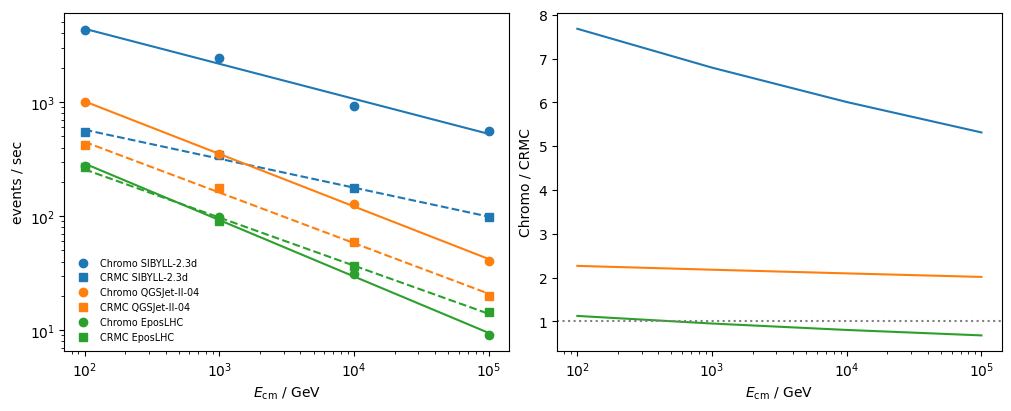

In [26]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares


def line(x, a, b):
    return a + b * x


with open("timing.pkl", "rb") as f:
    timing = pickle.load(f)

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 4), constrained_layout=True)
for model, (times_chromo, times_crmc) in timing.items():
    plt.sca(ax[0])
    li = plt.plot(energies, times_chromo, "o", label=f"Chromo {model}")[0]
    par = Minuit(LeastSquares(np.log(energies), np.log(times_chromo), 1, line), 0, 0).migrad().values
    chromo_line = np.exp(line(np.log(energies), *par))
    plt.plot(energies, chromo_line, color=li.get_color())
    plt.plot(energies, times_crmc, "s", label=f"CRMC {model}", color=li.get_color())
    par = Minuit(LeastSquares(np.log(energies), np.log(times_crmc), 1, line), 0, 0).migrad().values
    crmc_line = np.exp(line(np.log(energies), *par))
    plt.plot(energies, crmc_line, color=li.get_color(), ls="--")
    plt.sca(ax[1])
    print(chromo_line / crmc_line)
    plt.plot(energies, chromo_line / crmc_line, color=li.get_color())
plt.sca(ax[0])
plt.xlabel("$E_\\mathrm{cm}$ / GeV")
plt.ylabel("events / sec")
plt.loglog()
plt.legend(frameon=False, fontsize="x-small")
plt.sca(ax[1])
plt.axhline(1, ls=":", color="0.5")
plt.xlabel("$E_\\mathrm{cm}$ / GeV")
plt.ylabel("Chromo / CRMC")
plt.semilogx()
plt.savefig("timing.pdf");
